In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import time

In [ ]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()


In [ ]:
import pandas as pd
data=pd.read_csv('gdp.csv')
data.head

<bound method NDFrame.head of        t        GDP_VN
0   1984  3.436346e+10
1   1985  3.567129e+10
2   1986  3.666626e+10
3   1987  3.798019e+10
4   1988  3.993047e+10
5   1989  4.287116e+10
6   1990  4.505798e+10
7   1991  4.774382e+10
8   1992  5.187177e+10
9   1993  5.605924e+10
10  1994  6.101430e+10
11  1995  6.683536e+10
12  1996  7.307780e+10
13  1997  7.903516e+10
14  1998  8.359110e+10
15  1999  8.758140e+10
16  2000  9.352583e+10
17  2001  9.931778e+10
18  2002  1.060000e+11
19  2003  1.130000e+11
20  2004  1.210000e+11
21  2005  1.310000e+11
22  2006  1.400000e+11
23  2007  1.500000e+11
24  2008  1.580000e+11
25  2009  1.670000e+11
26  2010  1.770000e+11
27  2011  1.890000e+11
28  2012  1.990000e+11
29  2013  2.100000e+11
30  2014  2.240000e+11
31  2015  2.390000e+11
32  2016  2.550000e+11
33  2017  2.730000e+11
34  2018  2.930000e+11
35  2019  3.150000e+11
36  2020  3.240000e+11
37  2021  3.320000e+11>

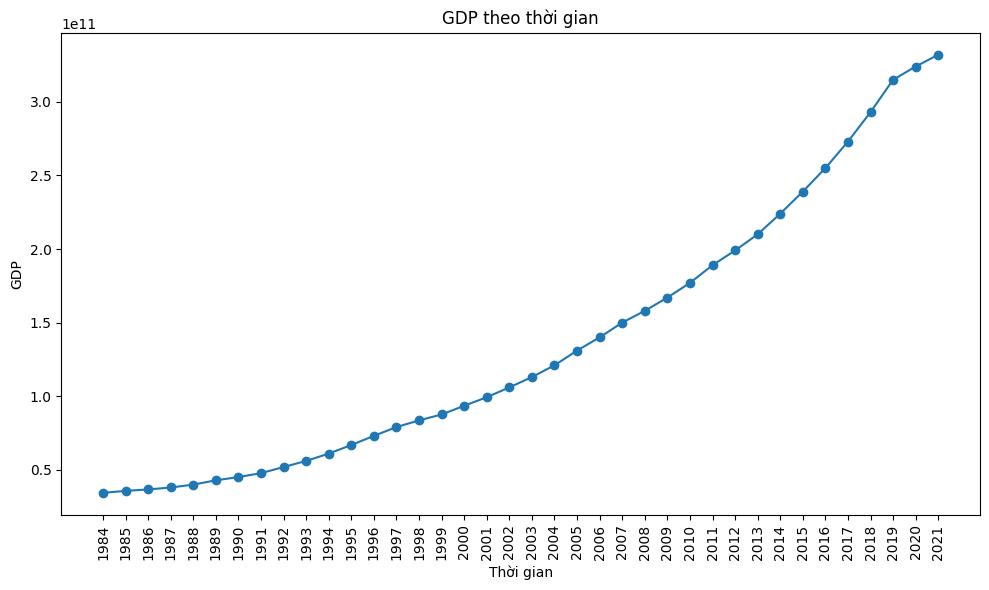

In [ ]:
import csv
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists
time_step = []
cpi = []

# Open CSV file
with open('gdp.csv', 'r') as csvfile:
    # Initialize reader
    reader = csv.reader(csvfile)

    # Skip the first line
    next(reader)

    # Append values to lists
    for row in reader:
        time_step.append(row[0])  # Thời gian (ví dụ: "Jan-95")
        cpi.append(float(row[1]))  # CPI

# Convert lists to numpy arrays (cho cột CPI)
series = np.array(cpi)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(time_step, series, marker='o', linestyle='-')
plt.xlabel('Thời gian')
plt.ylabel('GDP')
plt.title('GDP theo thời gian')
plt.xticks(rotation=90)  # Xoay nhãn trục x cho dễ đọc
plt.tight_layout()
plt.show()


In [ ]:
# Define the split time
split_time =int( 0.85*len(series))

# Get the train set
time_train = time_step[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time_step[split_time:]
x_valid = series[split_time:]
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
import time
start_time = time.time()
# Build the Model
# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])

# Train the model
history = model.fit(dataset,epochs=100)
end_time = time.time()
train_time_cls = end_time - start_time
print(f'Thời gian huấn luyện mô hình RNN: {train_time_cls:.4f} giây')

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 231499988992.0000 - mse: 53648500057103201730560.0000
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 231499988992.0000 - mse: 53648500057103201730560.0000
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 231499988992.0000 - mse: 53648500057103201730560.0000
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 231499988992.0000 - mse: 53648500057103201730560.0000
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 231499988992.0000 - mse: 53648500057103201730560.0000
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 231499988992.0000 - mse: 53648500057103201730560.0000
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 231499988992.0000 - mse: 53648500057103201730560.0000
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 231499988992.0000 - mse: 53648500057103201730560.0000
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 231499988992.0000 - mse: 536485000571032017305

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


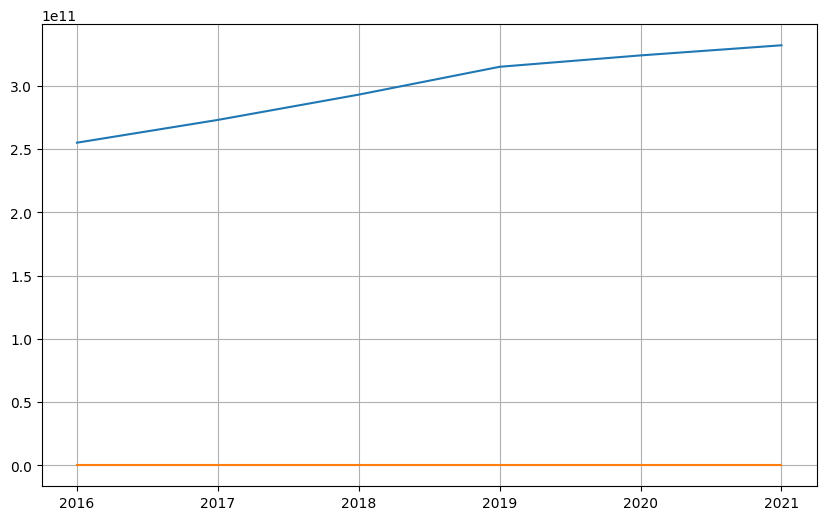

[211.73973 211.73973 211.73973 211.73973 211.73973 211.73973]
MSE: 8.997133320685413e+22
Mean Error Percent: 0.999999999284651
Accuracy: 7.15349002256005e-10


In [ ]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))


print(results)

# Giả sử x_valid và results là các mảng dự đoán và giá trị thực
x_valid = np.array(x_valid)
results = np.array(results)

# Tính Mean Squared Error
mse = np.mean(np.square(x_valid - results))
print("MSE:", mse)

# Tính Mean Absolute Percentage Error (MAPE)
non_zero_indices = x_valid != 0  # Đảm bảo không có giá trị 0 trong mẫu
mean_error_percent = np.mean(np.abs((x_valid[non_zero_indices] - results[non_zero_indices]) / x_valid[non_zero_indices]))
accuracy = 1 - mean_error_percent  # Tính accuracy từ MAPE

print("Mean Error Percent:", mean_error_percent)
print("Accuracy:", accuracy)
